In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print('Importing data...')
data = {
    'train': pd.read_csv('../input/application_train.csv'),
    'test': pd.read_csv('../input/application_test.csv'),
    'bb': pd.read_csv('../input/bureau_balance.csv'),
    'b': pd.read_csv('../input/bureau.csv'),
    'ccb': pd.read_csv('../input/credit_card_balance.csv'),
    'ip': pd.read_csv('../input/installments_payments.csv'),
    'POSb': pd.read_csv('../input/POS_CASH_balance.csv'),
    'previous': pd.read_csv('../input/previous_application.csv'),
    'description': pd.read_csv('../input/HomeCredit_columns_description.csv')
    }

Importing data...


In [3]:
pd.set_option("display.max_columns",100)

# Training and testing dataset

In [4]:
data['train'].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

In [5]:
data['train'].shape
# (307511, 122)

(307511, 122)

__1. target distribution__

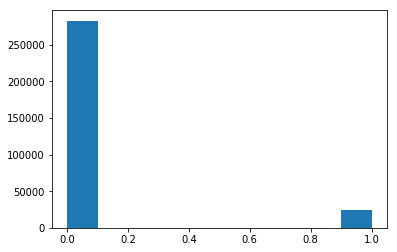

In [8]:
y = data['train']['TARGET']
plt.hist(y)
plt.show()

The label looks highly imbalanced. I use ROC AUC score as performance metric and it will be helpful for model validation. To perform feature engineering on training and testing data together, I concatened the two datasets.

In [36]:
df = pd.concat([data['train'],data['test']])
train_row = data['train'].shape[0]

__2. categorical features__

In [37]:
# summary of categorical features
def cat_info(df):
    cat_vars = list(df.select_dtypes(include = ['object']).columns)
    uniqs = []
    for col in cat_vars:
        n_uniq = len(df.loc[:,col].unique())
        uniqs.append(n_uniq)
    return pd.DataFrame({'Categorical features': cat_vars,'No. unique categories':uniqs})

cat_info(df)

,Categorical features,No. unique categories
0,CODE_GENDER,3
1,EMERGENCYSTATE_MODE,3
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
4,FONDKAPREMONT_MODE,5
5,HOUSETYPE_MODE,4
6,NAME_CONTRACT_TYPE,2
7,NAME_EDUCATION_TYPE,5
8,NAME_FAMILY_STATUS,6
9,NAME_HOUSING_TYPE,6


By examing the categorical features, I found some categorical data use 'XNA' instead of np.nan as NA values. So next I will replace 'XNA' as np.nan values.

In [38]:
# find 'XNA'
df.replace('XNA',np.nan,inplace = True)

In [39]:
cat = cat_info(df)
bin_f = cat[cat['No. unique categories'] == 2]
bin_f

,Categorical features,No. unique categories
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
6,NAME_CONTRACT_TYPE,2


Some features are not categorical, but are also binary, so I will find these features in the numerical features.

In [164]:
def bin_num(df):
    binary_f = []
    for c in df.columns:
        if len(df[c].unique())==2 and c not in bin_f:
            binary_f.append(c)
    return binary_f

bin_num = bin_num(df)

In [40]:
def cat_levels(df,cat_info):
    cat_f = df[cat_info['Categorical features']]
    levels = {}
    for c in cat_f:
        level = list(df[c].unique())
        levels.update({c:level})
    return pd.DataFrame.from_dict(levels,orient='index')

cat_levels(df,cat_info(df))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
CODE_GENDER,M,F,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
EMERGENCYSTATE_MODE,No,NaN,Yes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
FLAG_OWN_CAR,N,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
FLAG_OWN_REALTY,Y,N,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
FONDKAPREMONT_MODE,reg oper account,NaN,org spec account,reg oper spec account,not specified,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
HOUSETYPE_MODE,block of flats,NaN,terraced house,specific housing,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
NAME_CONTRACT_TYPE,Cash loans,Revolving loans,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
NAME_EDUCATION_TYPE,Secondary / secondary special,Higher education,Incomplete higher,Lower secondary,Academic degree,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
NAME_FAMILY_STATUS,Single / not married,Married,Civil marriage,Widow,Separated,Unknown,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
NAME_HOUSING_TYPE,House / apartment,Rented apartment,With parents,Municipal apartment,Office apartment,Co-op apartment,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


From the above information of categorical features, I found 'WEEKDAY_APPR_PROCESS_START' is a feature may be encoded by LabelEncoder, but I still chosed to use OneHotEncoding to avoid possible missing feature characteristics.

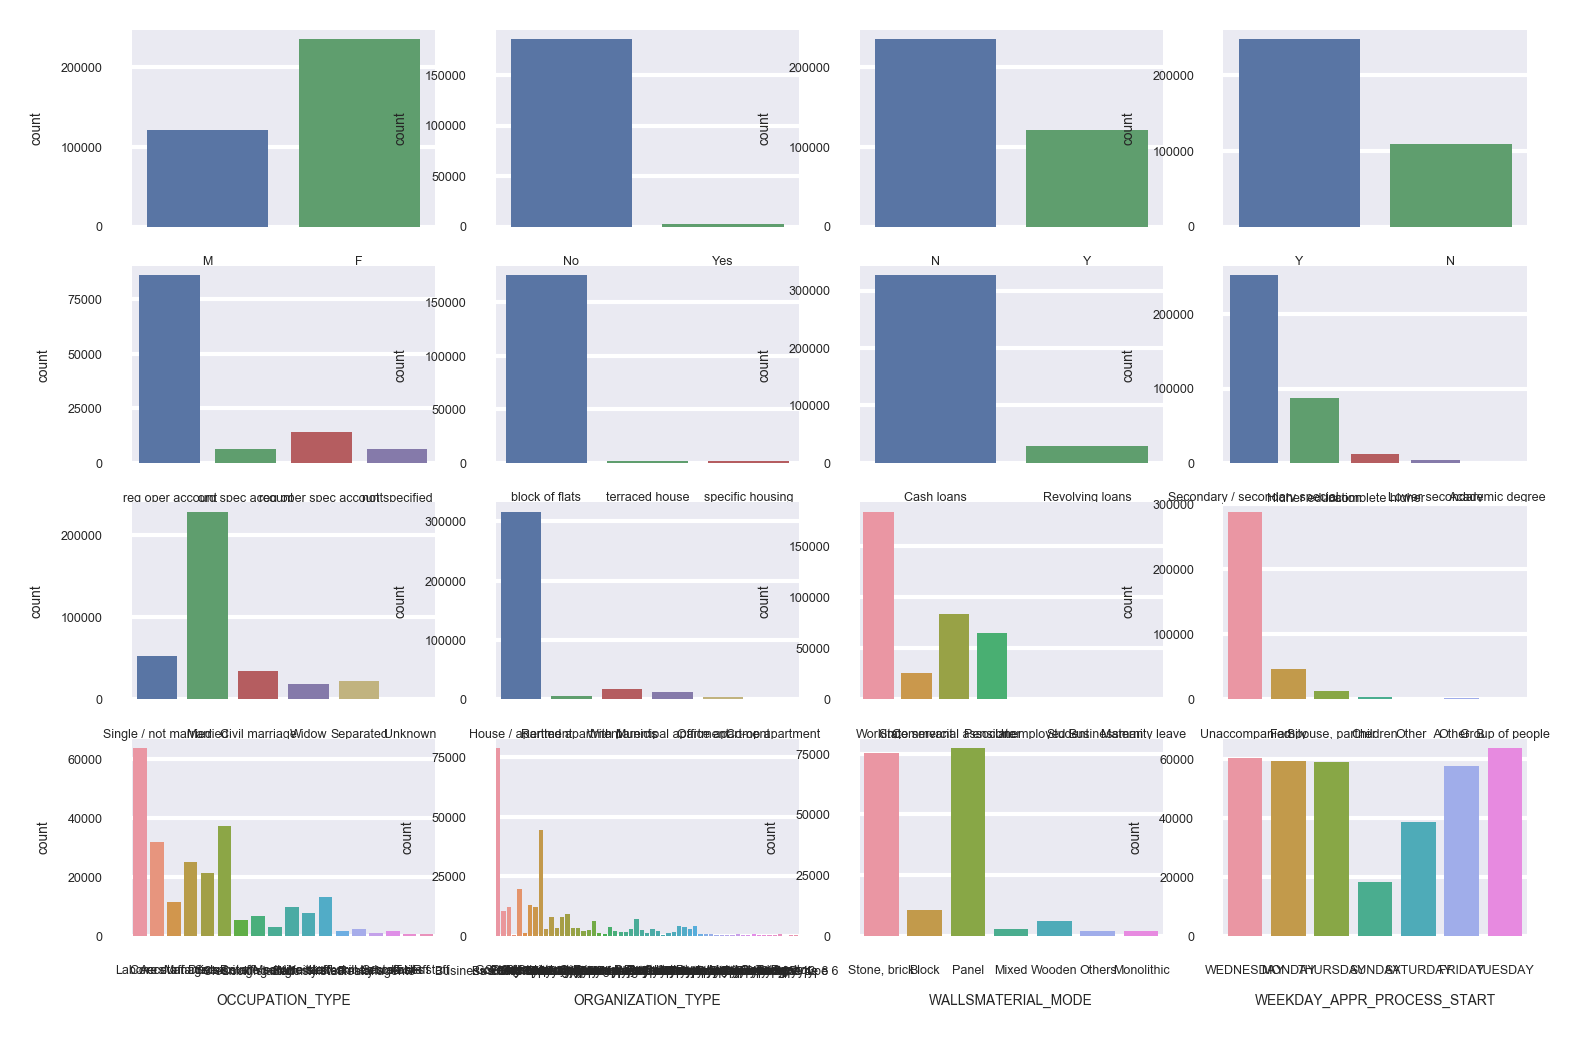

In [132]:
# percentage distribution of categorical features' categories
%matplotlib inline

plt.rcParams['figure.dpi'] = 300

# plt.figure(figsize=(20,10))
fig, ax = plt.subplots(4,4)

for i in range(len(cat)):
    c = cat['Categorical features'][i]
    row = i//4
    col = i%4
    sns.countplot(x=c, data=df,ax = ax[row,col])
    sns.set(font_scale = 0.5)

plt.show()

__2. numerical features__

In [165]:
# find aberrant numerical features
def num_abberrant(df):
    num_df = df.describe()
    abb = []
    for n in num_df.columns:
        low = num_df[n]['mean']-3*num_df[n]['std']
        up = num_df[n]['mean']+3*num_df[n]['std']
        if num_df[n]['min'] < low or num_df[n]['max'] > up:
            abb.append(n)
    return num_df[abb]

num_abb = num_abberrant(df.drop(bin_num,axis=1))
num_abb

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,HOUR_APPR_PROCESS_START,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT_W_CITY,TARGET,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
count,356219.000000,3.562550e+05,3.559770e+05,3.562550e+05,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,176307.000000,176307.000000,176307.000000,148671.000000,148671.000000,148671.000000,356255.000000,356253.000000,107895.000000,107895.000000,107895.000000,356254.000000,356255.000000,355205.000000,355205.000000,167175.000000,167175.000000,167175.000000,177848.000000,177848.000000,177848.000000,179914.000000,179914.000000,179914.000000,115147.000000,115147.000000,115147.000000,356255.000000,145411.000000,145411.000000,145411.000000,113276.000000,113276.000000,113276.000000,178353.000000,178353.000000,178353.000000,109394.000000,109394.000000,109394.000000,160489.000000,160489.000000,160489.000000,355205.000000,355205.000000,121014.000000,356255.000000,356255.000000,307511.000000,185200.000000,183392.000000,183392.000000,183392.000000,119949.000000,119949.000000,119949.000000
mean,27425.560657,5.877674e+05,5.280200e+05,1.701161e+05,0.006281,0.005808,0.231697,0.304399,0.029995,1.911564,0.118138,0.118549,0.114914,0.088673,0.088178,0.087750,0.414316,2.151858,0.045045,0.044994,0.042930,-978.580852,-4983.593527,0.143452,0.100198,0.079819,0.078930,0.075346,0.150015,0.149494,0.145471,0.227331,0.226922,0.223315,0.232817,0.232504,0.228878,12.055749,0.066454,0.067296,0.065092,0.101495,0.102674,0.106382,0.108089,0.109279,0.106641,0.008868,0.008697,0.008116,0.028503,0.028386,0.027183,1.425729,1.409468,12.023741,0.020917,2.028932,0.080729,0.103193,0.977889,0.977903,0.977239,0.752283,0.755548,0.759452
std,14732.808190,3.986237e+05,3.660650e+05,2.235068e+05,0.104250,0.079736,0.855949,0.786915,0.191374,1.865338,0.108954,0.109824,0.108745,0.082312,0.082017,0.084076,0.720378,0.907937,0.077045,0.077140,0.075437,835.063902,3526.968986,0.456579,0.368259,0.135249,0.135133,0.133025,0.100139,0.100450,0.101088,0.145051,0.145453,0.144126,0.161909,0.162419,0.161725,3.267576,0.081287,0.082267,0.081911,0.093418,0.094541,0.098779,0.111194,0.112881,0.112555,0.047876,0.047519,0.046330,0.069880,0.070574,0.070723,2.599914,2.577724,11.880848,0.013915,0.504586,0.272419,0.108041,0.057929,0.058562,0.063165,0.113267,0.112057,0.110112
min,1615.500000,4.500000e+04,4.050000e+04,2.565000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-4361.000000,-24672.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000253,-1.000000,0.000000,0.000000,0.000000,0.000000,0

In [167]:
num_abb.shape

(8, 66)

The above summary screened out 92 'abberrant' numerical features. I find a lot of features are actually binary, so I need to put these features in the binary features categories. So I go back and add a __bin_num__ function and change the input of __num_abberrant__ function. After that, the number of 'abberrant' features goes down to 66. From these changes, I find it most useful to go through each feature one by one.

In [216]:
# load data description
description = pd.read_csv('../input/HomeCredit_columns_description.csv',encoding = "cp1252")

In [217]:
dp_app = description[description['Table'] == 'application_{train|test}.csv'].iloc[:,2:]
dp_app

,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample,NaN
1,TARGET,Target variable (1 - client with payment diffi...,NaN
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,CODE_GENDER,Gender of the client,NaN
4,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,CNT_CHILDREN,Number of children the client has,NaN
7,AMT_INCOME_TOTAL,Income of the client,NaN
8,AMT_CREDIT,Credit amount of the loan,NaN
9,AMT_ANNUITY,Loan annuity,NaN


To start with these 122 features, I group them by the 'Special' column.

In [218]:
dp_app['Special'].unique()

array([nan, 'normalized ', 'time only relative to the application',
       'rounded', 'normalized'], dtype=object)

In [236]:
normalized_f = dp_app['Row'][dp_app['Special'] == 'normalized']
# I find 'REGION_POPULATION_RELATIVE' is also normalized data but is not picked up by the algorithm
# append 'REGION_POPULATION_RELATIVE' to normalized features
normalized_f = list(normalized_f.append(dp_app['Row'][dp_app['Special'] == 'normalized ']))

In [220]:
time_to_app_f = list(dp_app['Row'][dp_app['Special'] == 'time only relative to the application'])
rounded_f = list(dp_app['Row'][dp_app['Special'] == 'rounded'])
other_f = list(dp_app['Row'][dp_app['Special'].isnull()])

In [239]:
# make sure all features are included
len(normalized_f) + len(time_to_app_f) + len(rounded_f) + len(other_f) == len(dp_app)

True

In [277]:
normal_num_f = [f for f in normalized_f if f not in list(cat['Categorical features'])]

In [261]:
df_describe = df.describe
# all values in normalized data should be in [0,1]
def new_num_abb(df):
    norm_abb = []
    for c in df.columns:
        if df[c].dropna().between(0,1).all() == False:
            print('Values of column ' + c + ' not in range [0,1].')
            norm_abb.append(c)
    return norm_abb

In [278]:
norm_abb(df[normal_num_f])

EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAPARTMENTS_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
COMMONAREA_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAPARTMENTS_MEDI
LIVINGAREA_MEDI
NONLIVINGAPARTMENTS_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MODE
REGION_POPULATION_RELATIVE


[]

In [260]:
df['HOUSETYPE_MODE'].unique()

array(['block of flats', nan, 'terraced house', 'specific housing'],
      dtype=object)

In [253]:
df['EXT_SOURCE_1']

0        0.083037
1        0.311267
2             NaN
3             NaN
4             NaN
5             NaN
6        0.774761
7             NaN
8        0.587334
9             NaN
10       0.319760
11       0.722044
12       0.464831
13            NaN
14       0.721940
15       0.115634
16            NaN
17            NaN
18            NaN
19            NaN
20       0.565655
21       0.437709
22            NaN
23            NaN
24            NaN
25       0.561948
26            NaN
27            NaN
28       0.600396
29       0.297914
           ...   
48714    0.623896
48715    0.554915
48716    0.361450
48717    0.725281
48718         NaN
48719    0.498882
48720    0.587915
48721    0.204548
48722         NaN
48723    0.448657
48724    0.478887
48725    0.642719
48726    0.563175
48727    0.574515
48728    0.787271
48729         NaN
48730    0.440056
48731    0.573130
48732    0.527067
48733    0.363857
48734    0.410389
48735         NaN
48736    0.851722
48737    0.442558
48738    0

In [ ]:
# distribution plot
def sns_distplot(dt,r,c,font_scale):
    for i in range(len(df)):
        fig, ax = plt.subplots(r,c)
        row = i//c
        col = i%c
        sns.distplot(dt.dropna(),ax = ax[row,col])
        sns.set(font_scale=font_scale)
    plt.show()

dt = df[num_abb.columns]
sns_distplot(dt,10,7,0.01)